In [2]:
import IPython
from google.colab import output

# Define the JavaScript code as a string
js = """
function ClickConnect() {
  console.log("Click colab-connect-button");
  var btn = document.querySelector("colab-connect-button");
  if (btn != null) {
    btn.click();
  } else {
    console.log("Button not found, trying to reconnect");
    btn = document.querySelector("colab-reconnect-button");
    if (btn != null) {
      btn.click();
    }
  }
}

setInterval(ClickConnect, 60000);
"""

# Display the JavaScript code in the Colab notebook to run it
display(IPython.display.Javascript(js))


<IPython.core.display.Javascript object>

In [3]:
import os

# Set the KAGGLE_CONFIG_DIR environment variable to point to the /content directory.
# This tells the Kaggle API where to find the kaggle.json configuration file, which contains your Kaggle credentials.
# The /content directory is commonly used in Google Colab for storing files.
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [4]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset #download dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:56<00:00, 34.9MB/s]
100% 2.04G/2.04G [00:56<00:00, 38.6MB/s]


In [5]:
!unzip /content/plantvillage-dataset.zip -d /content/   #unzip file


Streaming output truncated to the last 5000 lines.
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-47

In [7]:
# Install TensorFlow version 2.9.1.
!pip install tensorflow==2.9.1


In [8]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

In [9]:
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print ('modules loaded')

modules loaded


In [11]:
# Set the directory containing the dataset
data_dir = '/content/plantvillage dataset/color'

# Initialize empty lists to store file paths and corresponding labels
filepaths = []
labels = []

# List subdirectories within the main directory
folds = os.listdir(data_dir)

# Iterate over each subdirectory (class) in the dataset
for fold in folds:
    # Construct full path for the subdirectory
    foldpath = os.path.join(data_dir, fold)

    # List files within the subdirectory
    filelist = os.listdir(foldpath)

    # Iterate over each file in the subdirectory
    for file in filelist:
        # Construct full file path
        fpath = os.path.join(foldpath, file)

        # Append file path and corresponding label to lists
        filepaths.append(fpath)
        labels.append(fold)

# Create pandas Series for file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Concatenate Series objects along columns axis to create DataFrame
df = pd.concat([Fseries, Lseries], axis=1)

In [12]:
df


filepaths  \
0      /content/plantvillage dataset/color/Tomato___L...   
1      /content/plantvillage dataset/color/Tomato___L...   
2      /content/plantvillage dataset/color/Tomato___L...   
3      /content/plantvillage dataset/color/Tomato___L...   
4      /content/plantvillage dataset/color/Tomato___L...   
...                                                  ...   
54300  /content/plantvillage dataset/color/Tomato___T...   
54301  /content/plantvillage dataset/color/Tomato___T...   
54302  /content/plantvillage dataset/color/Tomato___T...   
54303  /content/plantvillage dataset/color/Tomato___T...   
54304  /content/plantvillage dataset/color/Tomato___T...   

                             labels  
0                Tomato___Leaf_Mold  
1                Tomato___Leaf_Mold  
2                Tomato___Leaf_Mold  
3                Tomato___Leaf_Mold  
4                Tomato___Leaf_Mold  
...                             ...  
54300  Tomato___Tomato_mosaic_virus  
54301  Tomato___Tomato_mosaic_virus  
54302  Tomato___Tomato_mosaic_virus  
54303  Tomato___Tomato_mosaic_virus  
54304  Tomato___Tomato_mosaic_virus  

[54305 rows x 2 columns]

In [13]:
# Extract labels from the DataFrame df
strat = df['labels']


In [14]:
# Split df into train_df and dummy_df
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)


In [15]:
# Further split dummy_df into valid_df and test_df
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)


In [16]:
# Define batch size and image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# ImageDataGenerator for data augmentation
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Generating data flow for training set
train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

# Generating data flow for validation set
valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

# Generating data flow for test set
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=batch_size)


Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


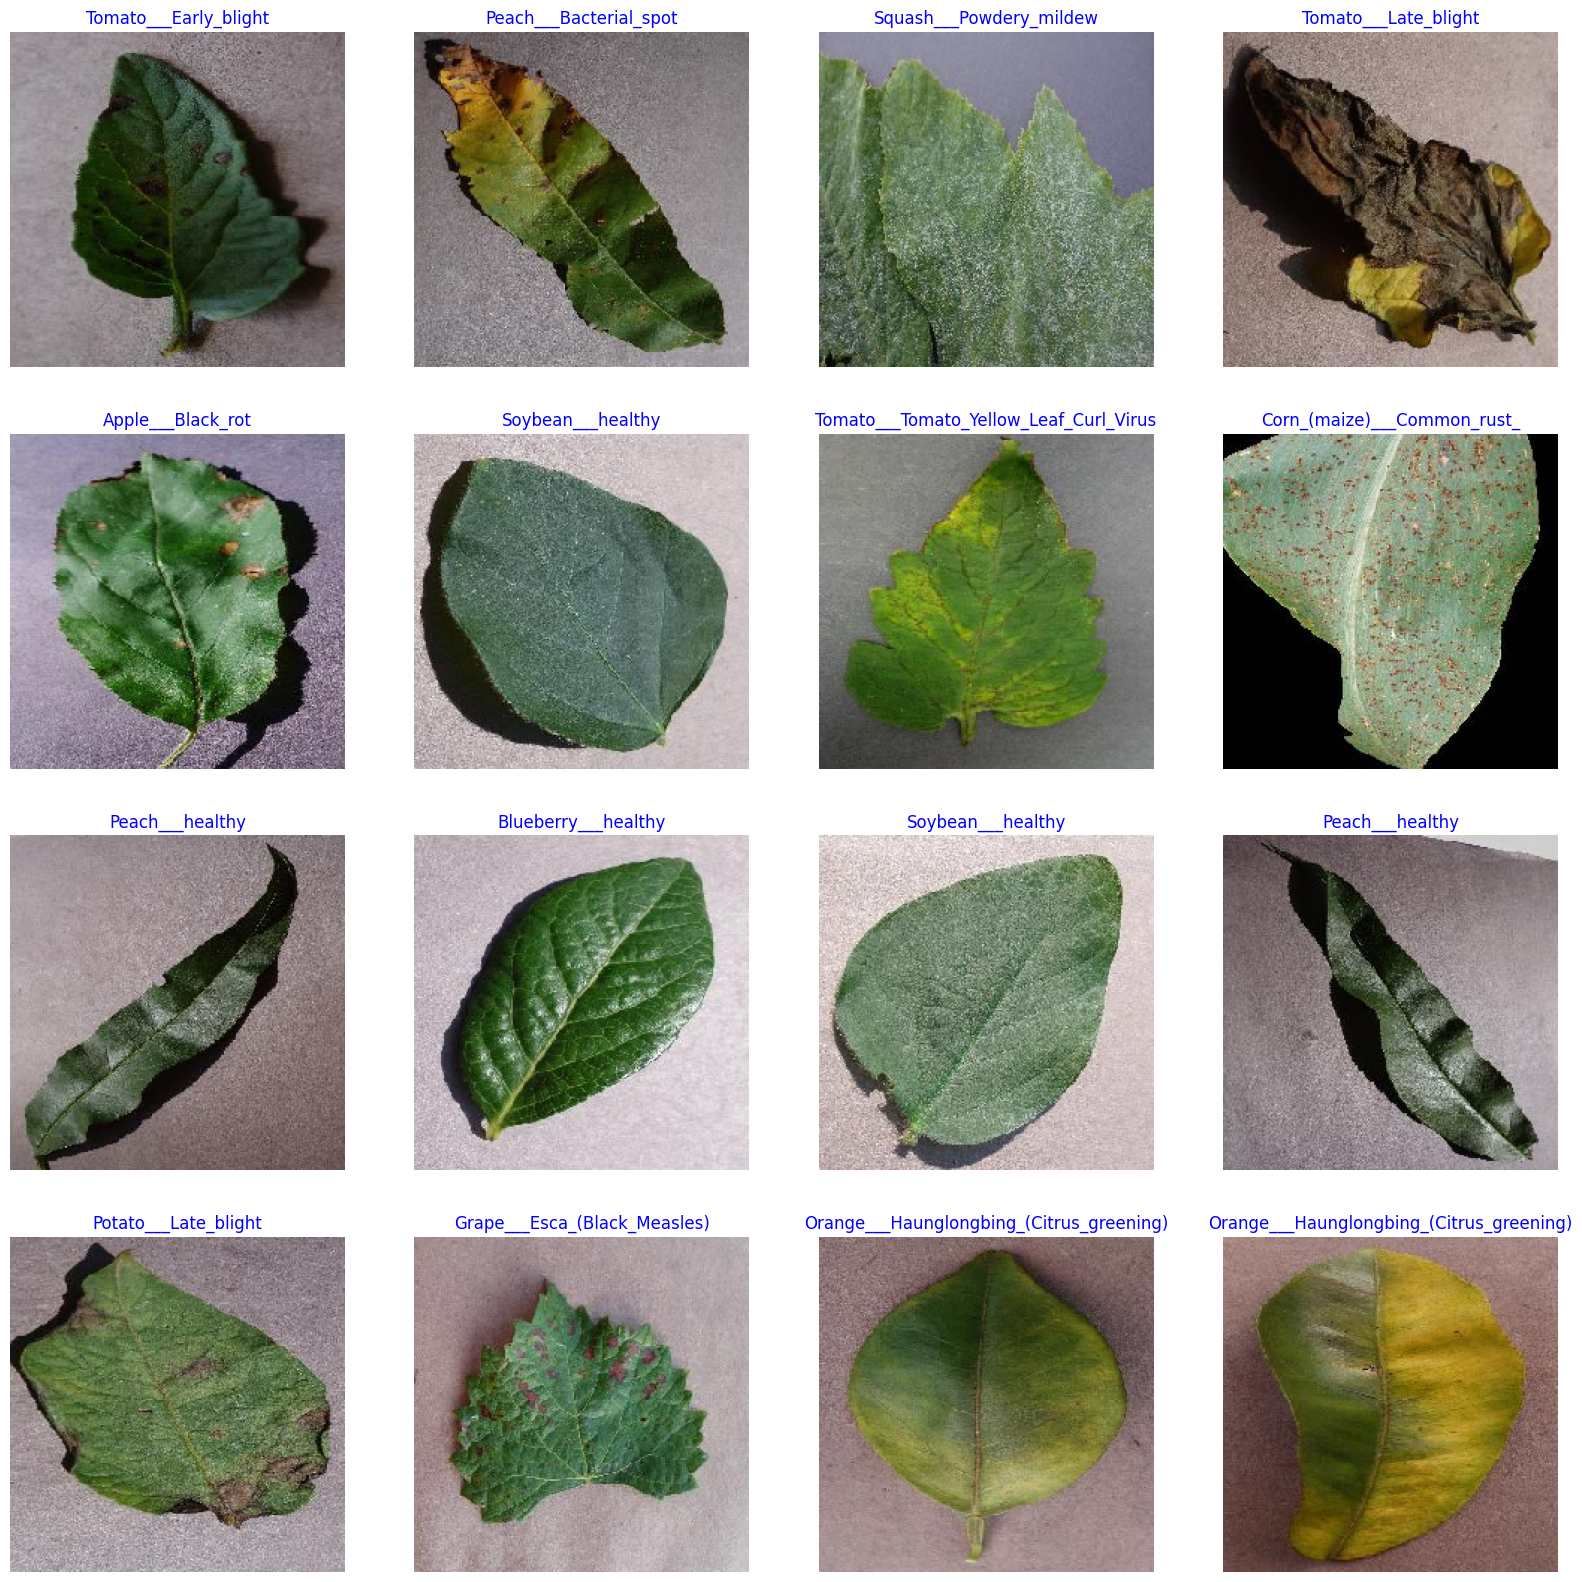

In [17]:
# Get the dictionary mapping class names to indices
g_dict = train_gen.class_indices

# Extract class names from the dictionary keys
classes = list(g_dict.keys())

# Get a batch of samples from the generator
images, labels = next(train_gen)

# Plotting the images
plt.figure(figsize=(20, 20))

# Loop through the batch of images
for i in range(16):
    # Create subplots
    plt.subplot(4, 4, i + 1)

    # Scale the image data to the range (0 - 1)
    image = images[i] / 255

    # Display the image
    plt.imshow(image)

    # Get the index of the label with the highest probability (one-hot encoding)
    index = np.argmax(labels[i])

    # Get the class name corresponding to the index
    class_name = classes[index]

    # Set the title of the subplot to the class name
    plt.title(class_name, color='blue', fontsize=12)

    # Turn off axis labels
    plt.axis('off')

# Show the plot
plt.show()


In [18]:
# Define image dimensions and shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Define the number of classes based on training data
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in the dense layer

# Load the pre-trained EfficientNetB5 model without the top (fully connected) layer
# This model is pre-trained on the ImageNet dataset
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,  # Exclude the top layer
    weights="imagenet",  # Use weights pre-trained on ImageNet
    input_shape=img_shape,  # Define the input shape
    pooling='max'  # Use global max pooling
)
base_model.trainable = False  # Freeze the base model to prevent training its weights

# Build the sequential model
model = Sequential([
    base_model,  # Add the pre-trained base model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Add batch normalization
    Dense(256,  # Add a dense layer with 256 units
          kernel_regularizer=regularizers.l2(0.016),  # Apply L2 regularization to the kernel
          activity_regularizer=regularizers.l1(0.006),  # Apply L1 regularization to the activity
          bias_regularizer=regularizers.l1(0.006),  # Apply L1 regularization to the bias
          activation='relu'),  # Use ReLU activation function
    Dropout(rate=0.45, seed=123),  # Add dropout with a rate of 0.45 to prevent overfitting
    Dense(class_count, activation='softmax')  # Output layer with softmax activation for classification
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),  # Use Adamax optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Use categorical crossentropy loss
    metrics=['accuracy']  # Evaluate the model with accuracy metric
)

# Display the model's architecture
model.summary()

115263384/115263384 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                                 
Total params: 29,056,029
Trainable params: 538,406
Non-

In [ ]:
# Define the number of epochs for training
epochs = 2  # number of all epochs in training

# Train the model
history = model.fit(
    x=train_gen,  # Training data generator
    epochs=epochs,  # Number of epochs to train
    verbose=1,  # Verbosity mode (1 = progress bar)
    validation_data=test_gen,  # Validation data generator
    shuffle=False  # Do not shuffle the data
)

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define variables from the training history
tr_acc = history.history['accuracy']  # Training accuracy for each epoch
tr_loss = history.history['loss']  # Training loss for each epoch
val_acc = history.history['val_accuracy']  # Validation accuracy for each epoch
val_loss = history.history['val_loss']  # Validation loss for each epoch

# Identify the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)  # Index of the epoch with the minimum validation loss
val_lowest = val_loss[index_loss]  # Minimum validation loss value

# Identify the epoch with the highest validation accuracy
index_acc = np.argmax(val_acc)  # Index of the epoch with the maximum validation accuracy
acc_highest = val_acc[index_acc]  # Maximum validation accuracy value

# Create a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]  # List of epoch numbers, starting from 1

# Labels for the scatter points
loss_label = f'best epoch= {str(index_loss + 1)}'  # Label for the best validation loss epoch
acc_label = f'best epoch= {str(index_acc + 1)}'  # Label for the best validation accuracy epoch

# Plot training history
plt.figure(figsize=(20, 8))  # Set the figure size
plt.style.use('fivethirtyeight')  # Use 'fivethirtyeight' style for the plot

# Plot training and validation loss
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')  # Plot training loss
plt.plot(Epochs, val_loss, 'g', label='Validation loss')  # Plot validation loss
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Highlight the best validation loss
plt.title('Training and Validation Loss')  # Set the title for the plot
plt.xlabel('Epochs')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend()  # Display the legend

# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')  # Plot training accuracy
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')  # Plot validation accuracy
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Highlight the best validation accuracy
plt.title('Training and Validation Accuracy')  # Set the title for the plot
plt.xlabel('Epochs')  # Set the x-axis label
plt.ylabel('Accuracy')  # Set the y-axis label
plt.legend()  # Display the legend

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()  # Display the plots